In [1]:
import torch
import torch.nn.functional as F
import glob
import h5py
import numpy as np
import os

/scratch/ondemand28/dsaragih/envs/coded-sensors/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = 'data/eccv_test_ours.h5'
with h5py.File(data_path,'r') as f:
    image_paths = f['test']
    input_params = {'height': image_paths.shape[-2],
                'width': image_paths.shape[-1]}

In [4]:
ckpt = torch.load(os.path.join('models', 'c2b_optimal.pth'), map_location='cpu')
print(f"Keys: {ckpt.keys()}")
c2b_code = ckpt['c2b_state_dict']['code']
code_repeat = c2b_code.repeat(1, 1, input_params['height']//8, input_params['width']//8)

print(f"Code shape: {c2b_code.shape}")
print(f"Code repeat shape: {code_repeat.shape}")
print(f"Input params: {input_params}")

Keys: dict_keys(['invnet_state_dict', 'unet_state_dict', 'c2b_state_dict'])
Code shape: torch.Size([1, 16, 8, 8])
Code repeat shape: torch.Size([1, 16, 128, 128])
Input params: {'height': 128, 'width': 128}


In [36]:
print(ckpt['unet_state_dict'].keys())
ckpt['unet_state_dict']['final_layer.4.bias'].shape

odict_keys(['conv_encode1.0.weight', 'conv_encode1.0.bias', 'conv_encode1.2.weight', 'conv_encode1.2.bias', 'conv_encode2.0.weight', 'conv_encode2.0.bias', 'conv_encode2.2.weight', 'conv_encode2.2.bias', 'conv_encode3.0.weight', 'conv_encode3.0.bias', 'conv_encode3.2.weight', 'conv_encode3.2.bias', 'bottleneck.0.weight', 'bottleneck.0.bias', 'bottleneck.2.weight', 'bottleneck.2.bias', 'bottleneck.5.weight', 'bottleneck.5.bias', 'conv_decode3.0.weight', 'conv_decode3.0.bias', 'conv_decode3.2.weight', 'conv_decode3.2.bias', 'conv_decode3.5.weight', 'conv_decode3.5.bias', 'conv_decode2.0.weight', 'conv_decode2.0.bias', 'conv_decode2.2.weight', 'conv_decode2.2.bias', 'conv_decode2.5.weight', 'conv_decode2.5.bias', 'final_layer.0.weight', 'final_layer.0.bias', 'final_layer.2.weight', 'final_layer.2.bias', 'final_layer.4.weight', 'final_layer.4.bias'])


torch.Size([16])

In [ ]:
print(f"Image paths shape: {image_paths.shape}")
"""
There's just one video sequence in the dataset. However, due to cropping, we get 56 in the batch dimension. For each, we have 16 frames. The current iteration has the 2nd bucket be the mean over the 16 frames.
"""

Image paths shape: (56, 16, 128, 128)


Image paths: <HDF5 dataset "test": shape (56, 16, 128, 128), type "<f8">
Image shape: torch.Size([1, 16, 128, 128])
Image min: 0.027450980392156862
Image max: 0.7725490196078432
b1 shape: torch.Size([1, 1, 128, 128])
b0 shape: torch.Size([1, 1, 128, 128])
b_stack shape: torch.Size([1, 2, 128, 128])


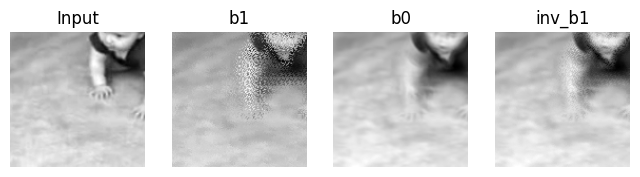

In [23]:
# Extract closed hdf5 dataset
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
with h5py.File(data_path,'r') as f:
    image_paths = f['test']
    print(f"Image paths: {image_paths}")
    image = torch.tensor(image_paths[1]).unsqueeze(0)
    print(f"Image shape: {image.shape}")
    print(f"Image min: {image.min()}")
    print(f"Image max: {image.max()}")
    b1 = torch.sum(code_repeat*image, dim=1, keepdim=True) / torch.sum(code_repeat, dim=1, keepdim=True)
    b0 = torch.mean(image, dim=1, keepdim=True)
    print(f"b1 shape: {b1.shape}")
    print(f"b0 shape: {b0.shape}")
    b_stack = torch.cat([b1,b0], dim=1)
    print(f"b_stack shape: {b_stack.shape}")
    inv_b1 = torch.sum((1-code_repeat)*image, dim=1, keepdim=True) / torch.sum(1-code_repeat, dim=1, keepdim=True)

    axs[0].imshow(image[0, 0], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Input')
    axs[1].imshow(b1[0, 0], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('b1')
    axs[2].imshow(b0[0, 0], cmap='gray')
    axs[2].axis('off')
    axs[2].set_title('b0')
    axs[3].imshow(inv_b1[0, 0], cmap='gray')
    axs[3].axis('off')
    axs[3].set_title('inv_b1')
plt.show()


#     for i in range(16):
#         axs[i//8, i%8].imshow(image[i], cmap='gray')
#         axs[i//8, i%8].axis('off')
# plt.show()


# # Plot (16, 128, 128)
# import matplotlib.pyplot as plt

# plt.imshow(test_image[0], cmap='gray')

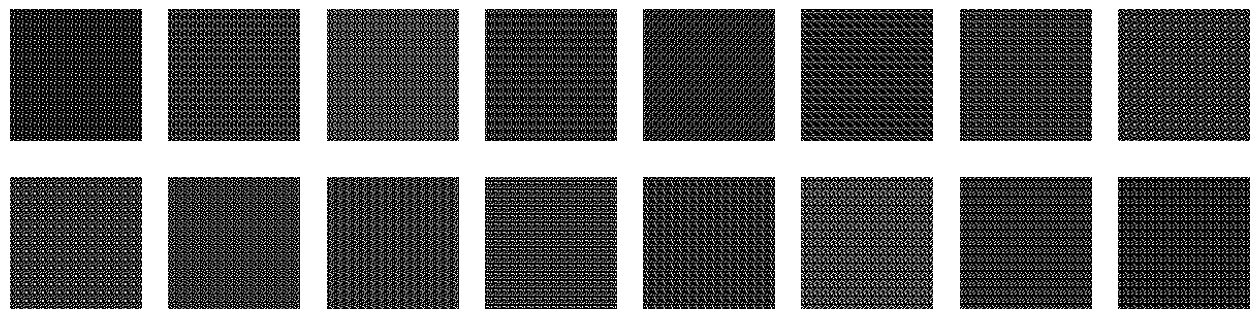

In [16]:
fig, ax = plt.subplots(2, 8, figsize=(16, 4))
# Plot code
for i in range(16):
    ax[i//8, i%8].imshow(code_repeat[0, i], cmap='gray')
    ax[i//8, i%8].axis('off')
plt.show()

In [1]:
from dataloader import Dataset_load, DavisData, SixGraySimData
from torch.utils import data
from sensor import C2B


data_path = "/scratch/ondemand28/dsaragih/datasets/DAVIS/JPEGImages/480p"
test_data_path = '/u8/d/dsaragih/diffusion-posterior-sampling/STFormer/test_datasets/simulation'
resize_h, resize_w = 128, 128
train_pipeline = [ 
    dict(type='RandomResize'),
    dict(type='RandomCrop',crop_h=resize_h,crop_w=resize_w,random_size=True),
    dict(type='Flip', direction='horizontal',flip_ratio=0.5,),
    dict(type='Flip', direction='diagonal',flip_ratio=0.5,),
    dict(type='Resize', resize_h=resize_h,resize_w=resize_w),
]
train_params = {'batch_size': 64,
                'shuffle': True,
                'num_workers': 2,}

## initializing training and validation data generators
# training_set = Dataset_load(data_path, dataset='train', num_samples='all')
c2b = C2B(block_size=2, sub_frames=4, mask="2x2", two_bucket=True)

training_set = DavisData(data_root=data_path, mask=c2b.code[0], pipeline=train_pipeline)
training_generator = data.DataLoader(training_set, **train_params)

sample = next(iter(training_generator))
c2b(sample)
code_repeat = c2b.code_repeat

/scratch/ondemand28/dsaragih/envs/coded-sensors/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
